- By: Ashutosh Singh
- Email: singh.ashu@gmail.com
- Reference: Advances in Financial Machine Learning, Marcos Lopez De Prado, pg 59


# Sample Weights

This chapter handles the challenge of sampling observations (with replacement) when they are not IID (independent and identically distributed). This is especially hard in financial data sets which are rarely IID. In the framework espoused by MLDP in AFML, observations are labeled using triple-barrier method. Therein, each label has a start time (given by the index) and an end time.  The end time corresponds to the time when one of the barriers is touched. Consider a hypothetical example of four labels - A, B, C and D with their start and end times.

A was generated at $t_1$ and triggered on $t_8$

B was generated at $t_3$ and triggered on $t_6$

C was generated on $t_7$ and triggered on $t_9$

D was generated on $t_10$ and triggered on $t_12$


In this case we see that A used information about returns on $[t_1,t_8]$ to generate label-endtime which overlaps with $[t_3, t_6]$ which was used by B and C, however D didn't use any returns information which was used by to label other samples. 

## Concurrency in labels

We say that labels $y_i$ and $y_j$ are concurrent at $t$ if they are a function of at least one common return at $r_{t-1,t}$. In the example above, in terms of concurrency label D is the cleanest as it doesn't use any piece of information from other labels, while A has most overlap as it uses information from both B and C. It is desirable to use a data set that has least amount of overlap to train an algorithm.   

We can measure average label uniqueness (or non-overlap) using get_av_uniqueness_from_tripple_barrier function from mlfinlab package. 

## Sampling with replacement  
Bagging algorithms resort to sampling with replacement (or bootstrapping) but when observations overlap with one another then bootstrapping is susceptible to creating samples which have redundancy. This makes the algorithms that use bootstrapping such as random forest inefficient because in-bag observations to be very similar to the out-of-bag ones, inflating the accuracy of out-of-bag accuracy.

## Sequenctial bootstrap process
In the first draw, an observation is drawn from the uniform distribution. For the second draw, the sequential bootstrap (SB) reduces the probability of the observation that was drawn earlier from being drawn again. This process continues until the required number of draws are made. To implement this scheme, we first need to determine all the bars that a label (of an observation) uses. We compute a binary matrix that has bars on one axis and the labels on the other (this is called indicator matrix). This matrix is then used to compute the the average uniqueness of each observation. 

The sequentially bootstrap process iteratively selects observations while adjusting the draw probabilities of each observation at each step of the loop.

## Notebook
In this notebook we provide the answers to the questions at the back of the Chapter 4.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


In [3]:
from mlfinlab.filters import filters
from mlfinlab.labeling import labeling
from mlfinlab.util import utils

In [4]:
from mlfinlab.sampling import concurrent
from mlfinlab.sampling import bootstrapping
from mlfinlab.util import multiprocess

In [5]:
%matplotlib inline

## 4.1 In Chapter 3. we denoted as t1 a pandas series of timestamps where the first barrier was touched, and the index was the timestamp of the observation. This was the output of the getEvents.

### 4.1 (a) Compute a t1 series on dollar bars derived from e-mini S&P 500 futures tick data

In [6]:
# Read in data
# data = pd.read_csv('official_data/dollar_bars.csv', nrows=40000)
data = pd.read_csv('../Sample-Data/dollar_bars.csv')

data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)
close_prices = data['close']

In [7]:
print(close_prices.head())
print(close_prices.describe())
print('\nNo of NANs: {:}'.format(close_prices.isna().sum()))

date_time
2015-01-01 23:00:23.723    2056.75
2015-01-02 07:07:35.156    2064.00
2015-01-02 09:35:57.204    2060.50
2015-01-02 12:59:42.176    2061.00
2015-01-02 14:19:33.847    2063.75
Name: close, dtype: float64
count    24079.000000
mean      2061.126864
std         88.690949
min       1805.750000
25%       2013.750000
50%       2073.250000
75%       2114.250000
max       2272.000000
Name: close, dtype: float64

No of NANs: 0


In [8]:
# Compute daily volatility
vol = utils.get_daily_vol(close=close_prices, lookback=50)

In [9]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = filters.cusum_filter(close_prices, threshold=vol.mean())

In [10]:
# Compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(cusum_events, close_prices, num_days=1)
vertical_barriers.head()

2015-01-02 15:39:14.826   2015-01-04 23:20:12.567
2015-01-02 20:47:02.488   2015-01-04 23:20:12.567
2015-01-04 23:20:12.567   2015-01-06 02:16:54.528
2015-01-05 14:49:36.175   2015-01-06 14:52:04.655
2015-01-05 16:10:05.172   2015-01-06 16:11:27.929
Name: date_time, dtype: datetime64[ns]

In [11]:
triple_barrier_events = labeling.get_events(close=close_prices,
                                               t_events=cusum_events,
                                               pt_sl=[1, 1],
                                               target=vol,
                                               min_ret=0.01,
                                               num_threads=1,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=None)

/media/ashu/data/Documents/WQU/Post-course/code/mlfinlab/mlfinlab/labeling/labeling.py:122: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [12]:
triple_barrier_events.head()

,t1,trgt
2015-01-09 17:13:19.851,2015-01-11 23:31:19.054,0.010065
2015-01-15 13:45:55.324,2015-01-15 14:57:17.741,0.010148
2015-01-15 14:39:34.621,2015-01-16 00:15:15.421,0.010703
2015-01-30 10:09:09.112,2015-02-01 23:26:29.558,0.011492
2015-01-30 14:48:27.262,2015-01-30 20:54:46.692,0.010769


In [13]:
# triple_barrier_events

### 4.1 (b) Apply the function mpNumCoEvents to compute the number of overlapping outcomes at each point in time

In [14]:
from mlfinlab.sampling import concurrent
from mlfinlab.util import multiprocess

In [15]:
num_threads = 1
num_conc_events = multiprocess.mp_pandas_obj(concurrent.num_concurrent_events, ('molecule', triple_barrier_events.index), num_threads, 
                                            close_series_index=close_prices.index, label_endtime=triple_barrier_events['t1'])

In [16]:
# eliminate the duplicates
num_conc_events = num_conc_events.loc[~num_conc_events.index.duplicated(keep='last')]

# reindex based on the close prices
num_conc_events = num_conc_events.reindex(close_prices.index).fillna(0)
len(num_conc_events)

24079

### 4.1 (c) Plot the time-series of the number of concurrent labels on the primary axis, and the time series of exponentially weighted moving standard deviation of returns on the secondary axis 

In [17]:
display_df = (pd.DataFrame()
              .assign(vol=vol,
                     num_conc_events=num_conc_events)
              .drop_duplicates().dropna()
             )

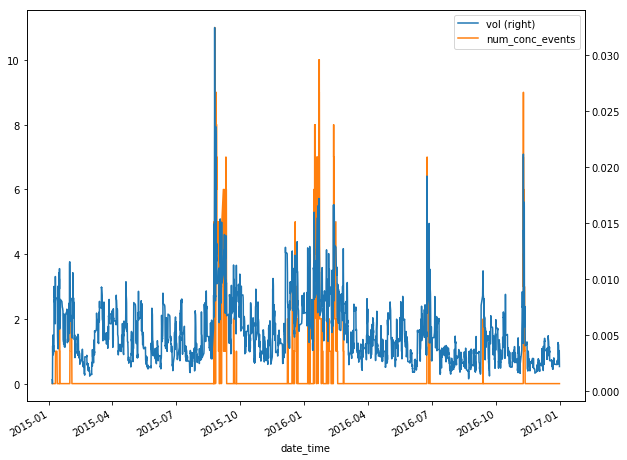

In [18]:
# display_df.plot()
display_df[['vol', 'num_conc_events']].plot(secondary_y='vol', figsize=(10,8))
plt.show()

### 4.1 (d) Produce a scatterplot of the number of concurrent labels (x-axis) and the exponentially weighted moving standard deviation of returns (y-axis). Can you appreciate the relationship?

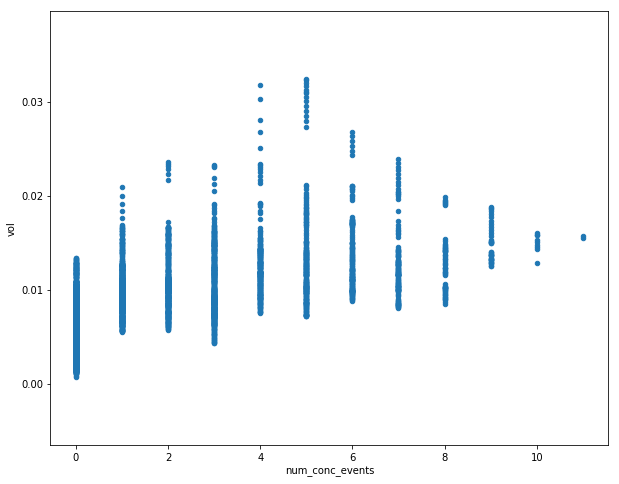

In [19]:
display_df.plot.scatter(x='num_conc_events', y='vol', figsize=(10, 8))
plt.show()

In [20]:
import seaborn as sns

/home/ashu/anaconda3/envs/p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


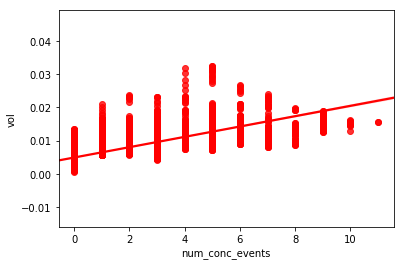

In [21]:
sns.regplot(x=display_df['num_conc_events'], y=display_df['vol'], color='r')
plt.show()

In [22]:
# try polyfit
x = display_df['num_conc_events']
y = display_df['vol']
z = np.polyfit(x, y, 2)
p = np.poly1d(z)

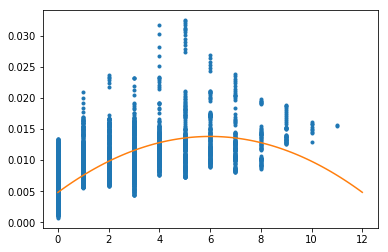

In [23]:
xp = np.linspace(0, max(x)+1, 100)
_ = plt.plot(x, y, '.', xp, p(xp), '-')

## 4.2 Using thefunction mpSampleTW, compute the average uniqueness of each label. What is the first-order serial correlation, AR(1), of this time series? Is it statistically significant? Why? 

In [24]:
out = multiprocess.mp_pandas_obj(concurrent._get_average_uniqueness, ('molecule', triple_barrier_events.index), num_threads, 
                                 label_endtime=triple_barrier_events['t1'], num_conc_events=num_conc_events)

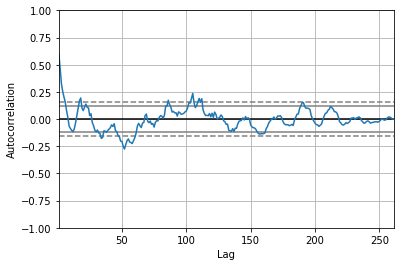

In [25]:
#ACF plot
pd.plotting.autocorrelation_plot(out)

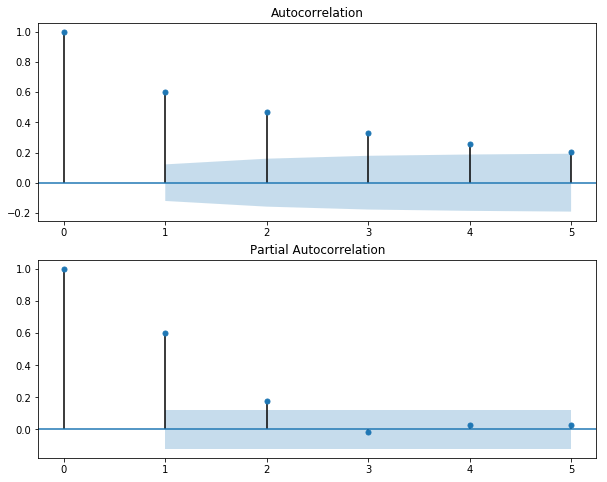

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(10, 8))
plt.subplot(211)
plot_acf(out, ax=plt.gca(), lags=5)
plt.subplot(212)
plot_pacf(out, ax=plt.gca(), lags=5)
plt.show()

*The ACF chart shows the auocorrelation of average uniqueness of labels. The fact that the series is statistically significant at lags 1 and 2 indicate that uniqueness persists over time.  4.1.(c) shows that number of concurrent events are mostly zero except when volatility spikes. When the number of concurrent events is zero, then uniqueness is high. This means that we can expect autocorrelation at some level. Here it is at lags 1 and 2.*

In [27]:
# out

## 4.3 Fit a random forest to a financial data set where the average uniqueness is de minimis   

In [28]:
# Read in data
# data = pd.read_csv('official_data/dollar_bars.csv', nrows=40000)
data = pd.read_csv('../Sample-Data/dollar_bars.csv')

data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)
data = data.loc['2015-02-03':'2015-08-31']
close_prices = data['close']

### 4.3 (a) What is the mean out-of-bag accuracy?

##### Define RSI 

In [29]:
# Compute RSI
def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

##### define Bollinger bands

In [30]:
def bbands(close_prices, window, no_of_stdev):
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [31]:
# compute bands
window = 50
data['avg'], data['upper'], data['lower'] = bbands(data['close'], window, no_of_stdev=1.5)
data.sample(10)

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower
date_time,,,,,,,,,,
2015-06-18 16:14:33.833,2113.25,2114.00,2112.50,2113.00,33284,70332937.00,2894,2100.858385,2117.718850,2083.997920
2015-08-28 17:50:50.135,1974.25,1977.75,1971.50,1976.75,35452,70005105.25,5397,1978.240271,1992.286586,1964.193956
2015-07-15 14:19:07.157,2103.50,2105.50,2103.25,2104.75,33307,70091777.00,3439,2097.625534,2111.816979,2083.434089
2015-05-06 17:36:05.070,2074.75,2075.00,2068.75,2070.00,33795,70003482.75,4022,2081.862966,2095.041295,2068.684637
2015-05-26 15:35:44.107,2103.00,2106.25,2103.00,2106.25,33266,70004057.25,3138,2115.390171,2129.989035,2100.791307
2015-07-31 12:30:56.027,2101.25,2103.00,2097.75,2102.75,33366,70062501.25,4216,2098.431183,2107.400478,2089.461888
2015-06-24 15:12:23.613,2114.75,2114.75,2111.50,2112.25,33130,70003717.50,4442,2113.864369,2118.705170,2109.023568
2015-08-11 12:21:13.262,2087.50,2089.00,2083.25,2083.50,33564,70025631.00,3113,2089.541515,2105.017313,2074.065717
2015-07-10 15:57:37.609,2071.75,2072.50,2070.25,2070.50,33835,70086385.00,3136,2060.621122,2073.732724,2047.509520


In [32]:
# Compute RSI
rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [33]:
# Compute sides
data['side'] = np.nan 

long_signals = (data['close'] <= data['lower']) 
short_signals = (data['close'] >= data['upper']) 

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

# Remove Look ahead bias by lagging the signal
data['side'] = data['side'].shift(1)

 1.0    340
-1.0    251
Name: side, dtype: int64


In [34]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)
print(data.side.value_counts())

 1.0    339
-1.0    251
Name: side, dtype: int64


In [35]:
# Compute daily volatility
daily_vol = utils.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = filters.cusum_filter(data['close'], threshold=daily_vol['2011-09-01':'2018-01-01'].mean() * 0.1)

# Compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

In [36]:
pt_sl = [0, 2]
min_ret = 0.0005
triple_barrier_events = labeling.get_events(close=data['close'],
                                            t_events=cusum_events,
                                            pt_sl=pt_sl,
                                            target=daily_vol,
                                            min_ret=min_ret,
                                            num_threads=2,
                                            vertical_barrier_times=vertical_barriers,
                                            side_prediction=data['side'])

/media/ashu/data/Documents/WQU/Post-course/code/mlfinlab/mlfinlab/labeling/labeling.py:122: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-07-13 14:13:54.902887 100.0% apply_pt_sl_on_t1 done after 0.0 minutes. Remaining 0.0 minutes.


In [37]:
# Averge uniqueness
avg_uniqueness = concurrent.get_av_uniqueness_from_tripple_barrier(triple_barrier_events, close_prices, num_threads=1)
print(avg_uniqueness.mean())

tW    0.246979
dtype: float64


In [38]:
labels = labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

 1.0    208
-1.0    125
Name: side, dtype: int64

### Features

In [39]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()


In [40]:
# Add Trending signals
raw_data['sma'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'sma'] = -1

In [41]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['close'] <= raw_data['lower'] 
short_signals = raw_data['close'] >= raw_data['upper'] 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [42]:
# Remove look ahead bias
raw_data = raw_data.shift(1)
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,...,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,fast_mavg,slow_mavg,sma
date_time,,,,,,,,,,,,,,,,,,,,,
2015-02-03 15:02:12.773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-03 15:07:20.968,2032.25,2034.50,2031.75,2032.25,34432.0,70002102.75,13165.0,2026.365845,2035.969525,2016.762165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-03 15:14:10.455,2032.25,2032.50,2030.00,2031.25,34466.0,70003717.00,10916.0,2026.790317,2036.190829,2017.389805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-03 15:21:15.748,2031.25,2031.50,2028.00,2029.50,34497.0,70012124.50,11723.0,2027.015090,2036.072304,2017.957877,...,NaN,NaN,-0.000492,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-03 15:27:12.943,2029.50,2030.75,2027.50,2030.00,34501.0,70005857.25,11184.0,2027.252318,2036.015327,2018.489310,...,NaN,NaN,-0.000862,-0.000492,NaN,NaN,NaN,NaN,NaN,NaN


#### Now get the data at the specified events

In [43]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['avg', 'upper', 'lower', 'open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']

### Fit a model

In [44]:
# Split data into training, validation and test sets
X_training_test = X
y_training_test = y
X_train, X_test, y_train, y_test = train_test_split(X_training_test, y_training_test, test_size=0.2, shuffle=False)

In [45]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

0    218
1     48
Name: bin, dtype: int64

##### Note that true positives (1) are a less than 25% of the false positives (0).  We would want to rebalance the class weights to pay more attention to true positives (and less to false positives)

In [46]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [47]:
# extract parameters
n_estimator = 100
depth = 5
c_random_state = 42
print(n_estimator, depth, c_random_state)

100 5 42


In [48]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator, oob_score=True,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())
print("Out-of-bag Accuracy (OOB Score): {:.6f}".format(rf.oob_score_))

Out-of-bag Accuracy (OOB Score): 0.812030


##### *The out of bag accuracy in a data-set that has low uniqueness is very high (81%) ... commenting on observations with low uniquness, section 4.5 of AFML, page 63 states, "random sampling will make out-of-bag examples very similar to in-the-bag ones, the OOB accuracy would be grossly inflated"*  

### 4.3 (b) what is the mean accuracy of k-fold cross-validation (without shuffling) on the same dataset?

In [49]:

# k-fold
no_of_folds = 5
kfold = KFold(shuffle=False, random_state=1, n_splits=no_of_folds)
print(kfold)

KFold(n_splits=5, random_state=1, shuffle=False)


In [50]:
accuracy_array = np.zeros(no_of_folds)
i = 0
for train_index, test_index in kfold.split(X_training_test):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train, y_train.values.ravel())

    y_pred_rf = rf.predict_proba(X_test)[:, 1]
    y_pred = rf.predict(X_test)
    accuracy_array[i] = accuracy_score(y_test, y_pred)
    i += 1
    # print(accuracy_score(y_test, y_pred))

In [51]:
print(accuracy_array)
print("Mean KFold accuracy: {:.6f}".format(np.mean(accuracy_array)))

[0.8358209  0.74626866 0.88059701 0.81818182 0.66666667]
Mean KFold accuracy: 0.789507


##### *The mean accuracy from KFold is 79% - 2 percentatge point lower than OOB accuracy score. The OOB score is more biased because in case of sampling with replacement, there is higher redundancy within the in-the-bag observations. This in turn causes overestimation of accuracy.*

## 4.4 Modify the code in Section 4.7 to apply an exponential time-decay factor   

In [52]:
# Snippet 4.11 Implementation of time-decay factors
def get_time_decay(tw, clf_last_w=1.):
    # apply piecewise-linear decay to observed uniqueness (tw)
    # newest observation gets weight=1, oldest observation gets weight=clf_last_w
    clf_w = tw.sort_index().cumsum()
    if clf_last_w >= 0:
        slope = (1. - clf_last_w) / clf_w.iloc[-1]
    else:
        slope = 1. /((clf_last_w + 1) * clf_w.iloc[-1])
    
    const = 1. - slope * clf_w.iloc[-1]
    clf_w = const + slope * clf_w
    clf_w[clf_w < 0] = 0
    print("Constant: {:.6f}, Slope: {:.6f}".format(const, slope))
    return clf_w


In [53]:
# implementation of exponential time-decay factors
def get_time_decay_exp_old(tw, decay_rate=1.0, percent_of_zero_wts=0.):
    clf_w = tw.sort_index().cumsum()
    last_value = clf_w.iloc[-1]

    # create the output weights array
    out_wts = np.zeros(len(clf_w))
    for i in np.arange(len(clf_w)):
        if i < int(round(len(clf_w) * percent_of_zero_wts)):
            out_wts[i] = 0
        else:
            out_wts[i] = np.exp((decay_rate - 1.) * (last_value - clf_w[i]))        
    return out_wts

def get_time_decay_exp(tw, decay_rate=1.0, percent_of_zero_wts=0.):
    clf_w = tw.sort_index().cumsum()
    last_value = clf_w.iloc[-1]

    # create the output weights array
    out_wts = [0. if i < int(round(len(clf_w) * percent_of_zero_wts)) else np.exp((decay_rate - 1.) * (last_value - clf_w[i])) for i in np.arange(len(clf_w))]
    return np.asarray(out_wts)

In [54]:
decay_p1 = get_time_decay(out, 1.)
decay_p75 = get_time_decay(out, .75)
decay_p5 = get_time_decay(out, .5)
decay_pm25 = get_time_decay(out, -.25)
decay_pm5 = get_time_decay(out, -0.5)

Constant: 1.000000, Slope: 0.000000
Constant: 0.750000, Slope: 0.002870
Constant: 0.500000, Slope: 0.005739
Constant: -0.333333, Slope: 0.015304
Constant: -1.000000, Slope: 0.022957


In [55]:
len(out)

261

In [56]:
decay_factor_linear_df = (pd.DataFrame(index=out.index)
                          .assign(
                              decay_p1=decay_p1,
                              decay_p75=decay_p75,
                              decay_p5=decay_p5,
                              decay_pm25=decay_pm25,
                              decay_pm5=decay_pm5
                              )
                      )

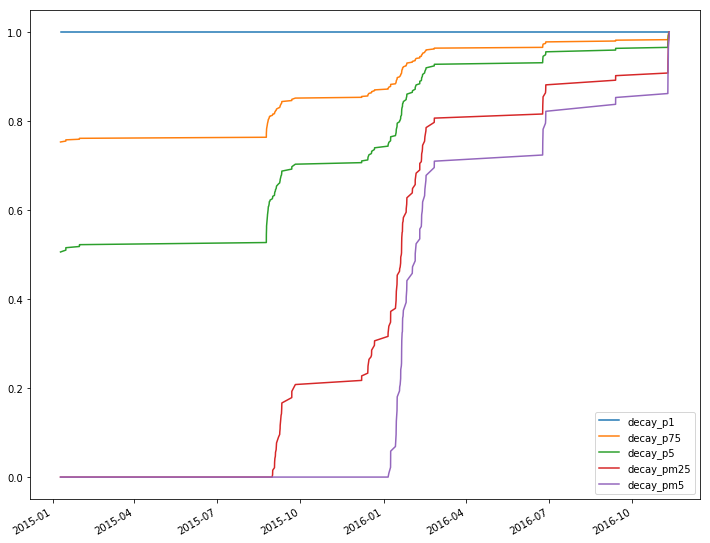

In [57]:
decay_factor_linear_df.plot(figsize=(12,10))

In [58]:
percent_of_zero_wts = 0.0
decay_rate = 0.94 
decay_exp_p99 = get_time_decay_exp(out, decay_rate=0.99, percent_of_zero_wts=percent_of_zero_wts)
decay_exp_p94 = get_time_decay_exp(out, decay_rate=0.94, percent_of_zero_wts=percent_of_zero_wts)
decay_exp_p100 = get_time_decay_exp(out, decay_rate=1.0, percent_of_zero_wts=percent_of_zero_wts)
decay_exp_p99_20 = get_time_decay_exp(out, decay_rate=0.99, percent_of_zero_wts=.2)
decay_exp_p94_20 = get_time_decay_exp(out, decay_rate=0.94, percent_of_zero_wts=0.2)

In [59]:
decay_factor_exp_df = (pd.DataFrame(index=out.index)
                       .assign(
                              decay_p99=decay_exp_p99,
                              decay_p94=decay_exp_p94,
                              decay_p100=decay_exp_p100,
                              decay_pm25=decay_exp_p99_20,
                              decay_pm5=decay_exp_p94_20
                              )
                      )

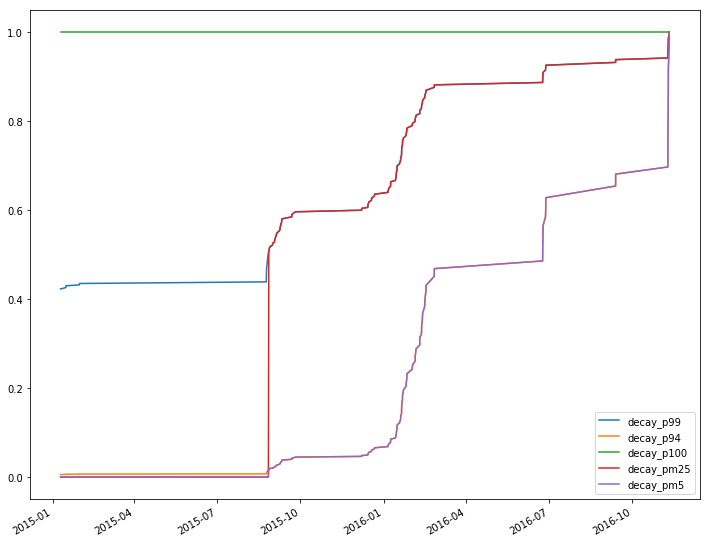

In [60]:
decay_factor_exp_df.plot(figsize=(12,10))

## 4.5 Consider you have applied meta-labels to events determined by a trend-following model. Suppose that two-thirds of the labels are 0 and one third of the labels are 1.


In [61]:
train_df['bin'].value_counts()

0    218
1     48
Name: bin, dtype: int64

In [62]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [63]:
# extract parameters
n_estimator = 100
depth = 5
c_random_state = 42
print(n_estimator, depth, c_random_state)

100 5 42


### 4.5.a What happens if you fit a classfier without balancing class weights

##### *Fit the random forest classifier and compute the performance metrics* 

In [64]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator, oob_score=True,
                            criterion='entropy', random_state=c_random_state)
print(rf)
rf.fit(X_train, y_train.values.ravel())
print("Out-of-bag Accuracy (OOB Score): {:.6f}".format(rf.oob_score_))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)
Out-of-bag Accuracy (OOB Score): 0.812030


In [65]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.92       218
           1       1.00      0.17      0.29        48

    accuracy                           0.85       266
   macro avg       0.92      0.58      0.60       266
weighted avg       0.87      0.85      0.80       266

Confusion Matrix
[[218   0]
 [ 40   8]]

Accuracy
0.849624060150376


##### *Although the accuracy is very high (84%), the recall of 1 (or true positive) is 17%. Recall is the fraction of the true positives that have been correctly picked. The confusion matrix says that TN or C(0,0) is 218 - 218 were true 0, with no mistakes in labeling FN or C(1,0) was zero. TP is C(1,1). Only 8 of the 48 were correctly labeled as 1.* 

In [66]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.89      0.79        47
           1       0.29      0.11      0.15        19

    accuracy                           0.67        66
   macro avg       0.50      0.50      0.47        66
weighted avg       0.59      0.67      0.61        66

Confusion Matrix
[[42  5]
 [17  2]]

Accuracy
0.6666666666666666


##### *When evaluating the out-of-sample data, the accuracy falls to 67%, the recall of 1 (or true positive) falls to 11%. Only 2 of the 19 labels were correctly identified.* 

### 4.5.b A label 1 means true positive, and a label 0 means false positive. By applying balanced class weights, we are forcing the classifer to pay more attention to the true positives, and less attention to the false positives. Why does that make sense?

*We would like the classifier to learn how to pick true positives and it can do that better when there are more observations to learn from.*

### 4.5.c What is the distribution of the predicted labels. before and after applying balanced class weights?

In [67]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator, oob_score=True,
                            class_weight='balanced_subsample', criterion='entropy', 
                            random_state=c_random_state)
print(rf)
rf.fit(X_train, y_train.values.ravel())
print("Out-of-bag Accuracy (OOB Score): {:.6f}".format(rf.oob_score_))

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=True,
                       random_state=42, verbose=0, warm_start=False)
Out-of-bag Accuracy (OOB Score): 0.804511


In [68]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [69]:
rf.fit(X_train, y_train.values.ravel())
print("Out-of-bag Accuracy (OOB Score): {:.6f}".format(rf.oob_score_))

Out-of-bag Accuracy (OOB Score): 0.804511


In [70]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       218
           1       0.98      0.96      0.97        48

    accuracy                           0.99       266
   macro avg       0.98      0.98      0.98       266
weighted avg       0.99      0.99      0.99       266

Confusion Matrix
[[217   1]
 [  2  46]]

Accuracy
0.9887218045112782


In [71]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77        47
           1       0.36      0.26      0.30        19

    accuracy                           0.65        66
   macro avg       0.54      0.54      0.54        66
weighted avg       0.62      0.65      0.63        66

Confusion Matrix
[[38  9]
 [14  5]]

Accuracy
0.6515151515151515


##### *In a balanced out-of-sample test, the recall of true positives increases to 26% from 11% - a 136% increase.* 

## 4.6 Update the draw probabilities for the final draw in Section 4.5.3


In [72]:
# Snippet 4.3
def get_ind_matrix(bar_ix, t1):
    # get indicator matrix
    ind_m = pd.DataFrame(0, index=bar_ix, columns=range(t1.shape[0]))
    for i, (t0, t1) in enumerate(t1.iteritems()):
        ind_m.loc[t0:t1, i] = 1
    return ind_m


def get_ind_mat_average_uniqueness(ind_mat):
    """
    Snippet 4.4. page 65, Compute Average Uniqueness
    Average uniqueness from indicator matrix

    :param ind_mat: (pd.Dataframe) indicator binary matrix
    :return: (float) average uniqueness
    """
    conc = ind_mat.sum(axis=1)  # concurrency
    unique = ind_mat.div(conc, axis=0)
    avg_unique = unique[unique > 0].mean()  # average uniqueness
    return avg_unique

In [73]:
# Set-up
tl = pd.Series([2, 3, 5], index=[0, 2, 4])  # t0, t1 for each feature obs
bar_ix = range(tl.max() + 1)
# ind_m = bootstrapping.get_ind_matrix(bar_ix, tl)
ind_m = get_ind_matrix(bar_ix, tl)


In [74]:
avg_u = pd.Series()
phi = [1, 2]

for i in ind_m:
    ind_m_ = ind_m[phi + [i]]
    # avg_u.loc[i] = bootstrapping.get_ind_mat_average_uniqueness(ind_m_).iloc[-1]
    avg_u.loc[i] = get_ind_mat_average_uniqueness(ind_m_).iloc[-1]

prob = avg_u / avg_u.sum()
print('Prob: {}\n'.format(prob))
phi += [np.random.choice(ind_m.columns, p=prob)]
print('Phi: {}'.format(phi))
print('-----------------')

Prob: 0    0.454545
1    0.272727
2    0.272727
dtype: float64

Phi: [1, 2, 2]
-----------------


## 4.7 Section 4.5.3, suppose that number 2 is picked again in the second draw. What would the updated probabilities for the third draw?


In [75]:
# Set-up
tl = pd.Series([2, 3, 5], index=[0, 2, 4])  # t0, t1 for each feature obs
bar_ix = range(tl.max() + 1)
ind_m = get_ind_matrix(bar_ix, tl)

In [76]:
# 4.7
phi = [1, 1]
for i in ind_m:
    ind_m_ = ind_m[phi + [i]]
    avg_u.loc[i] = get_ind_mat_average_uniqueness(ind_m_).iloc[-1]

prob = avg_u / avg_u.sum()
print('Prob: {}\n'.format(prob))
phi += [np.random.choice(ind_m.columns, p=prob)]
print('Phi: {}'.format(phi))
print('-----------------')

Prob: 0    0.368421
1    0.157895
2    0.473684
dtype: float64

Phi: [1, 1, 1]
-----------------


In [ ]:
# Completed